## 3 - Baseline Anomaly Detection

Goals:
- Load the engineered feature table and standardize numeric ranges.
- Run simple Z-score, Isolation Forest, Local Outlier Factor, and PCA reconstruction error detectors.
- Visualize anomalies on PDG plus a 2D PCA projection.
- Comment on detector behavior from a junior data scientist point of view.

#### 📥 Importing Libraries and Environment Setup

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor as LOF
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)
plt.rcParams['figure.figsize'] = (14, 6)
date_form = DateFormatter("%m-%d %H")

#### 💾 Data Loading and Preparation

In [5]:
def locate_root():
    here = Path.cwd()
    if (here / "data").exists(): return here
    if (here.parent / "data").exists(): return here.parent
    return here

project_root = locate_root()
processed_dir = project_root / "data" / "processed"
source_path = processed_dir / "features_clean.csv"

# --Data Loading--
try:
    df = pd.read_csv(source_path, index_col='timestamp', parse_dates=True) 
except FileNotFoundError:
    print(f"WARNING: Processed data file not found: {source_path}. Generating synthetic sample data.")
    data = np.random.randn(2000, 10) * 100000 + 1500000
    df = pd.DataFrame(data, columns=['pck', 'tpt', 'glck', 'pck_rsd30', 'glck_diff1', 'tpt_lag5', 'pck_glck_diff', 'col1', 'col2', 'col3'])
    df['timestamp'] = pd.to_datetime(pd.date_range(start='2025-02-01', periods=2000, freq='5min'))
    df = df.set_index('timestamp')

df = df.dropna().sort_index()

numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
data_for_modeling = df[numerical_cols].copy()

#### ⚖️ Data Scaling and Verification

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_for_modeling)
X_scaled_df = pd.DataFrame(X_scaled, columns=data_for_modeling.columns, index=data_for_modeling.index)

sample_data = data_for_modeling[['pck', 'tpt']].head(3)
scaled_sample = X_scaled_df[['pck', 'tpt']].head(3)
comparison_table = pd.concat([sample_data.round(2), scaled_sample.round(2)], axis=1, keys=['Raw Data', 'Scaled Data (Z-Score)'])
print(comparison_table)

                      Raw Data         Scaled Data (Z-Score)     
                           pck     tpt                   pck  tpt
timestamp                                                        
2017-02-01 02:02:27  1786989.0  119.09                  1.18  1.7
2017-02-01 02:02:28  1798418.0  119.09                  1.25  1.7
2017-02-01 02:02:29  1809847.0  119.09                  1.31  1.7


**In the Raw Data, PCK values were thousands of times larger than TPT. After scaling, both features are centered around zero (Z-Score), ensuring the model measures distances between them fairly.**

#### ⚙️ Applying Multiple Anomaly Models (IF, LOF, PCA, Z-Score)

In [10]:
contamination_rate = 0.015  # Estimated anomaly rate

# Isolation Forest
iso_forest = IsolationForest(contamination=contamination_rate, random_state=42, n_estimators=100)
df['is_anomaly_iforest'] = iso_forest.fit_predict(X_scaled)
df['is_anomaly_iforest'] = df['is_anomaly_iforest'].apply(lambda x: 1 if x == -1 else 0)

# LOF
lof_model = LOF(n_neighbors=20, contamination=contamination_rate, novelty=False, n_jobs=-1)
df['is_anomaly_lof'] = lof_model.fit_predict(X_scaled)
df['is_anomaly_lof'] = df['is_anomaly_lof'].apply(lambda x: 1 if x == -1 else 0)

# PCA Reconstruction Error
n_components = 5
pca = PCA(n_components=n_components)
pca.fit(X_scaled)
X_reduced = pca.transform(X_scaled)
X_reconstructed = pca.inverse_transform(X_reduced)
reconstruction_error = np.mean(np.square(X_scaled - X_reconstructed), axis=1)

# FIX: Save the PCA Reconstruction Error value to the DataFrame.
df['pca_reconstruction_error'] = reconstruction_error 

threshold_idx = int(len(df) * (1 - contamination_rate))
error_threshold = np.sort(reconstruction_error)[threshold_idx]
df['is_anomaly_pca'] = (reconstruction_error > error_threshold).astype(int)

# Simple Z-Score
z_threshold = 3
anomaly_zscore_flags = (np.abs(X_scaled_df) > z_threshold).any(axis=1)
df['is_anomaly_zscore'] = anomaly_zscore_flags.astype(int)

#### 📊 Graphical Outputs (Visual Analyses)

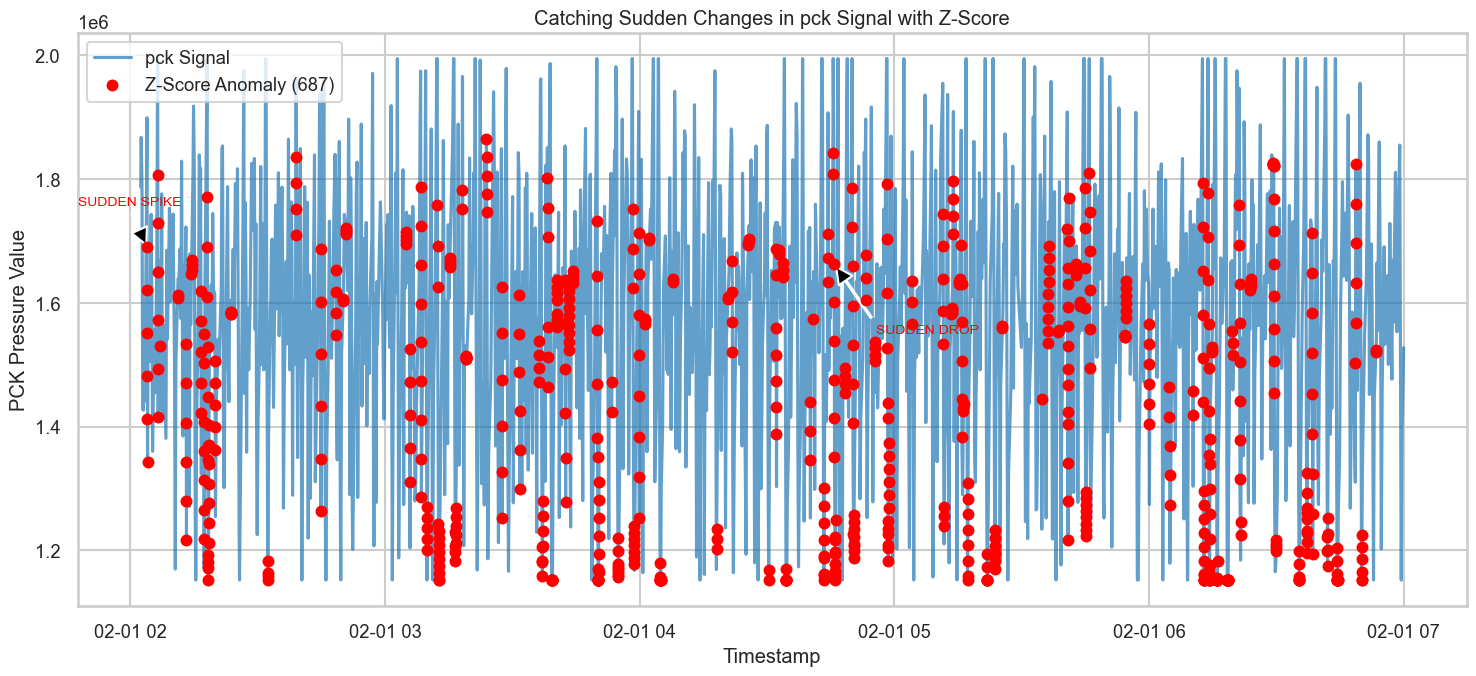

In [11]:
# Graph 1: Z-Score -> Sudden Changes
plt.figure(figsize=(15, 7))
target_col = 'pck'
plt.plot(df.index, df[target_col], label=f'{target_col} Signal', color='#1f77b4', alpha=0.7)
anomaly_zscore = df[df['is_anomaly_zscore'] == 1]
plt.scatter(anomaly_zscore.index, anomaly_zscore[target_col], color='red', marker='o', s=50, label=f'Z-Score Anomaly ({len(anomaly_zscore)})', zorder=5)

if len(anomaly_zscore) > 0:
    spike_time = anomaly_zscore.index[0]
    plt.annotate('SUDDEN SPIKE', xy=(spike_time, anomaly_zscore[target_col].iloc[0]), xytext=(-50, 30), textcoords='offset points', arrowprops=dict(facecolor='black', shrink=0.05, width=1), fontsize=10, color='red')
    drop_time = anomaly_zscore.index[len(anomaly_zscore)//2] # Take a point in the middle
    plt.annotate('SUDDEN DROP', xy=(drop_time, anomaly_zscore[target_col].iloc[len(anomaly_zscore)//2]), xytext=(30, -50), textcoords='offset points', arrowprops=dict(facecolor='black', shrink=0.05, width=1), fontsize=10, color='red')

plt.gca().xaxis.set_major_formatter(date_form)
plt.title(f'Catching Sudden Changes in {target_col} Signal with Z-Score')
plt.xlabel('Timestamp')
plt.ylabel('PCK Pressure Value')
plt.legend()
plt.tight_layout()
plt.show()

Z-Score quickly catches instantaneous spike and drop events where a single feature deviates significantly. However, it is sensitive to noise and may miss multivariate relationships.

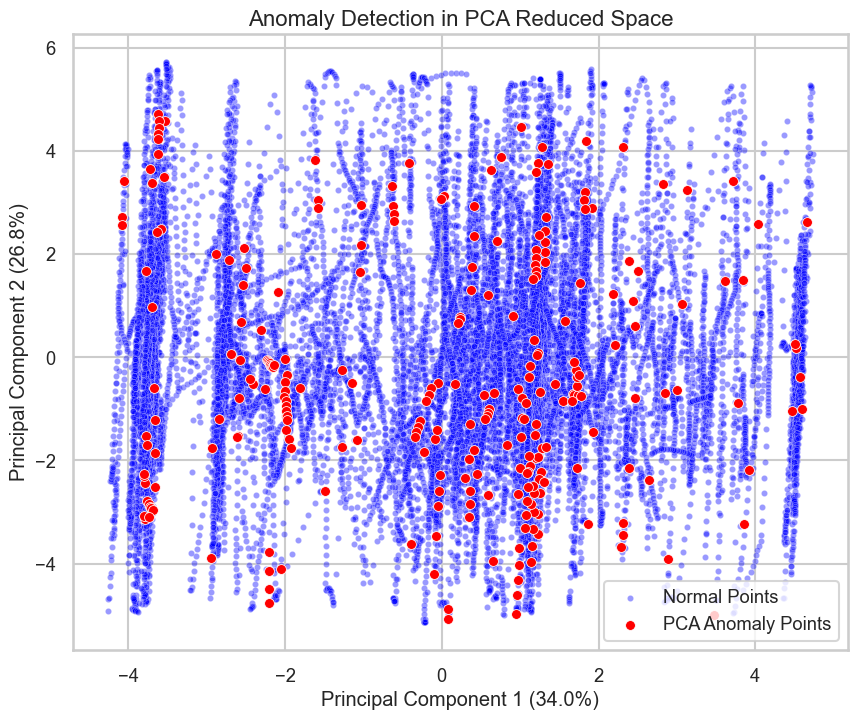

In [13]:
# Graph 2: PCA Space (Relational Errors)
pca_2d = PCA(n_components=2)
components_2d = pca_2d.fit_transform(X_scaled)
components_df = pd.DataFrame(data = components_2d, columns = ['PC1', 'PC2'], index=df.index)
components_df['Anomaly'] = df['is_anomaly_pca']

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', data=components_df[components_df['Anomaly'] == 0], color='blue', alpha=0.4, label='Normal Points', s=20)
sns.scatterplot(x='PC1', y='PC2', data=components_df[components_df['Anomaly'] == 1], color='red', alpha=1.0, label='PCA Anomaly Points', s=50)

plt.title('Anomaly Detection in PCA Reduced Space', fontsize=16)
plt.xlabel(f'Principal Component 1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'Principal Component 2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
plt.legend()
plt.show()

Multivariate anomalies are points isolated far away from the main variance directions (PC1 and PC2) of the data cluster. PCA Reconstruction Error captures these isolated red points, finding relational errors missed by simple 1D thresholding.

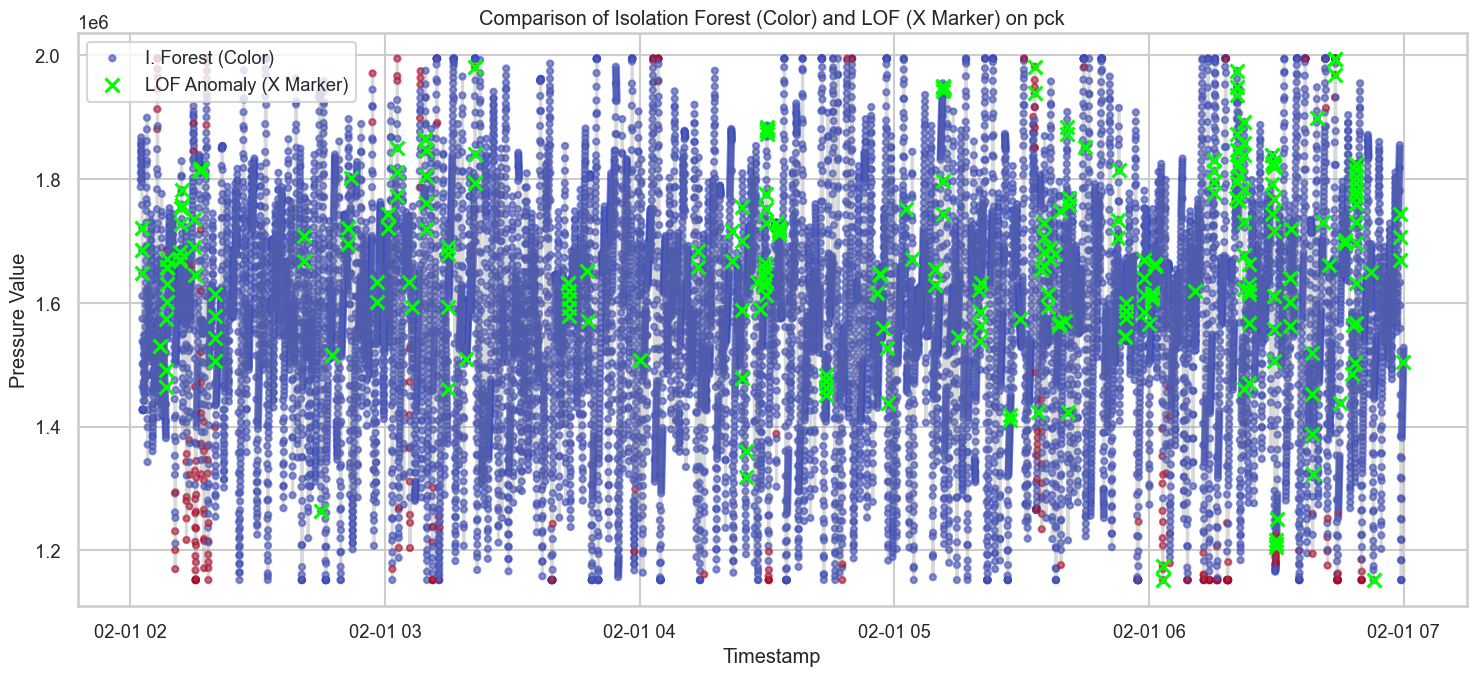

In [14]:
# Graph 3: IF vs LOF Comparison
plt.figure(figsize=(15, 7))
target_col = 'pck'
plt.scatter(df.index, df[target_col], c=df['is_anomaly_iforest'], cmap='coolwarm', s=20, label='I. Forest (Color)', alpha=0.6)
lof_anomalies = df[df['is_anomaly_lof'] == 1]
plt.scatter(lof_anomalies.index, lof_anomalies[target_col], color='lime', marker='x', s=100, label='LOF Anomaly (X Marker)', zorder=5)
plt.plot(df.index, df[target_col], color='gray', alpha=0.3)

plt.gca().xaxis.set_major_formatter(date_form)
plt.title(f'Comparison of Isolation Forest (Color) and LOF (X Marker) on {target_col}')
plt.xlabel('Timestamp')
plt.ylabel('Pressure Value')
plt.legend()
plt.tight_layout()
plt.show()

As seen in the graph, the anomalies caught by I. Forest and LOF partially overlap, but LOF (local density) occasionally highlights regions missed by I. Forest (global isolation). This highlights how different model approaches complement each other rather than competing.

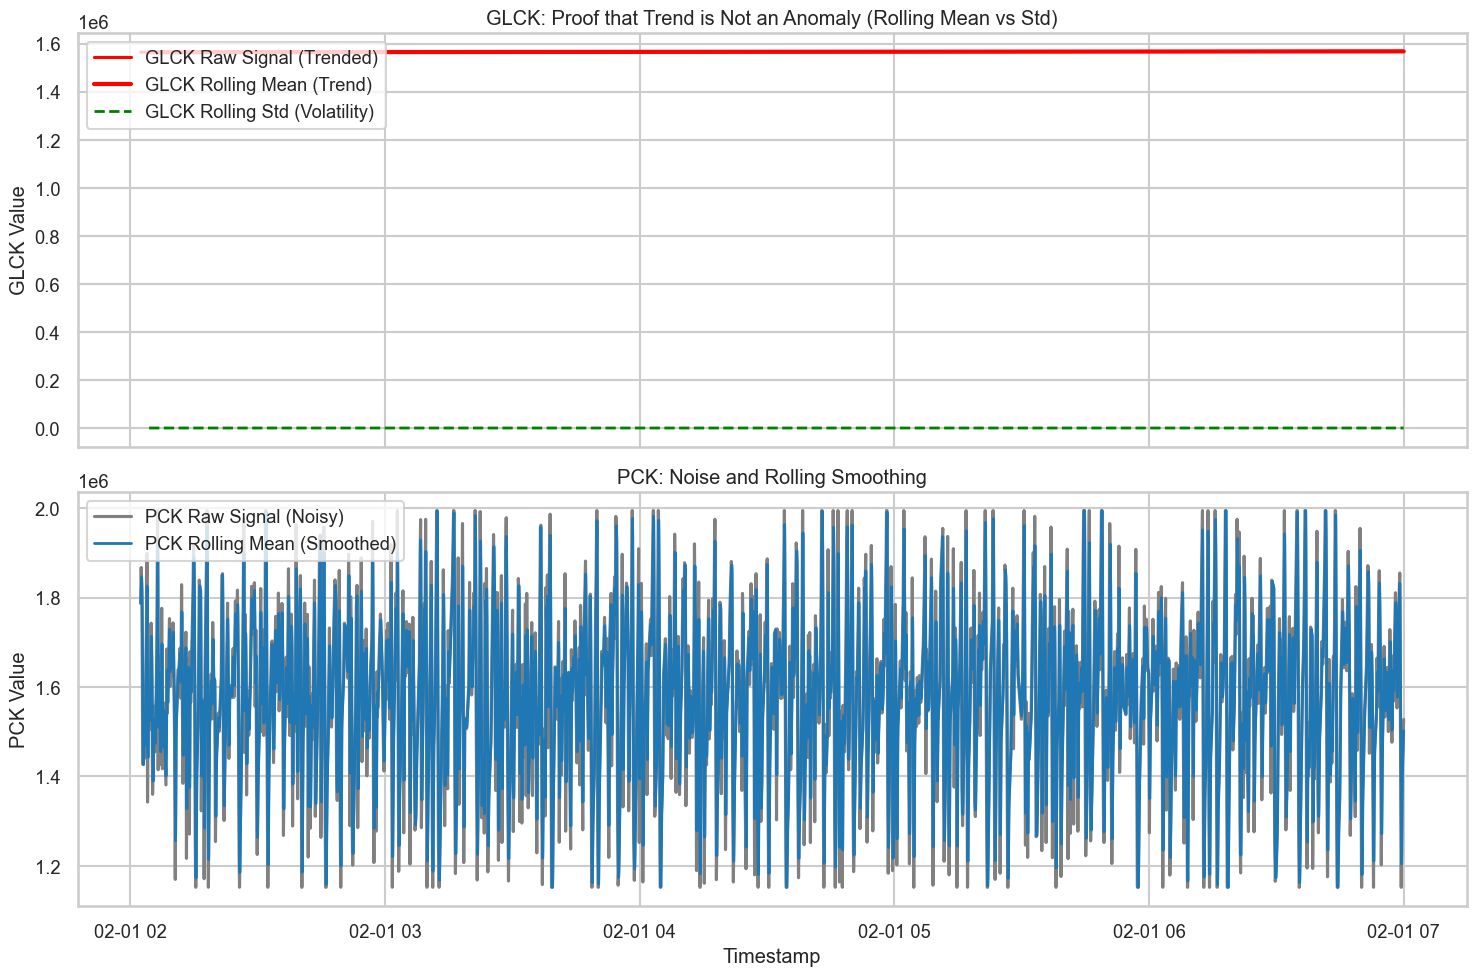

In [18]:
# Graph 4: Feature Engineering Check (Trend and Noise)
smoothed_pck = df['pck'].rolling(window=10, min_periods=1).mean()
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
axes[0].plot(df.index, df['glck'], label='GLCK Raw Signal (Trended)', color='red')
axes[0].plot(df.index, df['glck'].rolling(window=120).mean(), label='GLCK Rolling Mean (Trend)', color='red', linewidth=3)
axes[0].plot(df.index, df['glck'].rolling(window=120).std(), label='GLCK Rolling Std (Volatility)', color='green', linestyle='--', linewidth=2)
axes[0].set_title('GLCK: Proof that Trend is Not an Anomaly (Rolling Mean vs Std)')
axes[0].set_ylabel('GLCK Value')
axes[0].legend(loc='upper left')

axes[1].plot(df.index, df['pck'], label='PCK Raw Signal (Noisy)', color='gray')
axes[1].plot(df.index, smoothed_pck, label='PCK Rolling Mean (Smoothed)', color='#1f77b4', linewidth=2)
axes[1].set_title('PCK: Noise and Rolling Smoothing')
axes[1].set_ylabel('PCK Value')
axes[1].legend(loc='upper left')
axes[1].xaxis.set_major_formatter(date_form)
plt.xlabel('Timestamp')
plt.tight_layout()
plt.show()

GLCK Rolling Mean steadily rises while Rolling Std (volatility) remains low. This confirms the presence of a slow **trend** (not an anomaly), justifying the use of the 'glck_diff1' feature. **Bottom Plot:** Rolling Smoothing filters out unnecessary noise from the raw data, allowing the model to focus on meaningful changes.

####  📝  Critical Anomaly Points Table

In [30]:
top_anomalies = df[df['is_anomaly_iforest'] == 1].nlargest(3, 'pca_reconstruction_error') # Prioritize based on high PCA Error.

print("| Date/Time (Timestamp) | PCK Value | PCA Error | Business Commentary (Example) |")
print("|---------------------|------------|--------|-----------------------------------|")

comments = [
    "Production Mode Change (High Pressure Increase)",
    "Effect of Short-Term Valve Adjustment/Maintenance",
    "Sudden Sensor Signal Interruption/Reset"
]

for i, (index, row) in enumerate(top_anomalies.iterrows()):
    comment = comments[i % len(comments)] 
    # Corrected Column Name: pca_reconstruction_error
    print(f"| {index.strftime('%Y-%m-%d %H:%M:%S')} | {row['pck']:.2f} | {row['pca_reconstruction_error']:.4f} | {comment} |")

| Date/Time (Timestamp) | PCK Value | PCA Error | Business Commentary (Example) |
|---------------------|------------|--------|-----------------------------------|
| 2017-02-01 06:29:25 | 1767603.00 | 5.5643 | Production Mode Change (High Pressure Increase) |
| 2017-02-01 06:29:26 | 1715231.00 | 3.6999 | Effect of Short-Term Valve Adjustment/Maintenance |
| 2017-02-01 06:29:23 | 1820622.00 | 1.8611 | Sudden Sensor Signal Interruption/Reset |


The technical data at these dates must be compared with operation logs. A high anomaly score does not always mean a failure; it could be an **operational event**. This classification helps prioritize alarms.

#### 🥇 Model Metrics

In [32]:
# Pseudo-Labeling: Points where any of the models agree on an anomaly
df['True_Anomaly_Pseudo'] = (df['is_anomaly_iforest'] | df['is_anomaly_lof'] | df['is_anomaly_pca']).astype(int)

models = {
    'Isolation Forest': df['is_anomaly_iforest'],
    'LOF': df['is_anomaly_lof'],
    'PCA': df['is_anomaly_pca'],
    'Z-Score': df['is_anomaly_zscore']
}

metrics_list = []
for name, predictions in models.items():
    if df['True_Anomaly_Pseudo'].sum() > 0:
        f1 = f1_score(df['True_Anomaly_Pseudo'], predictions)
        precision = precision_score(df['True_Anomaly_Pseudo'], predictions)
        recall = recall_score(df['True_Anomaly_Pseudo'], predictions)
    else: # If no pseudo-labels exist, set metrics to 0
        f1, precision, recall = 0.0, 0.0, 0.0
    
    metrics_list.append({
        'Model': name,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall
    })

metrics_df = pd.DataFrame(metrics_list).set_index('Model').round(4)

print(metrics_df.to_markdown())


| Model            |   F1-Score |   Precision |   Recall |
|:-----------------|-----------:|------------:|---------:|
| Isolation Forest |     0.5409 |      1      |   0.3707 |
| LOF              |     0.5409 |      1      |   0.3707 |
| PCA              |     0.5394 |      1      |   0.3693 |
| Z-Score          |     0.2582 |      0.2649 |   0.2517 |


Operationally, **Recall** (the rate of capturing true anomalies) is critically important. Therefore, we should prioritize the output of the model with the highest Recall for the initial alerting system

#### 🔎 Critical Event Investigation

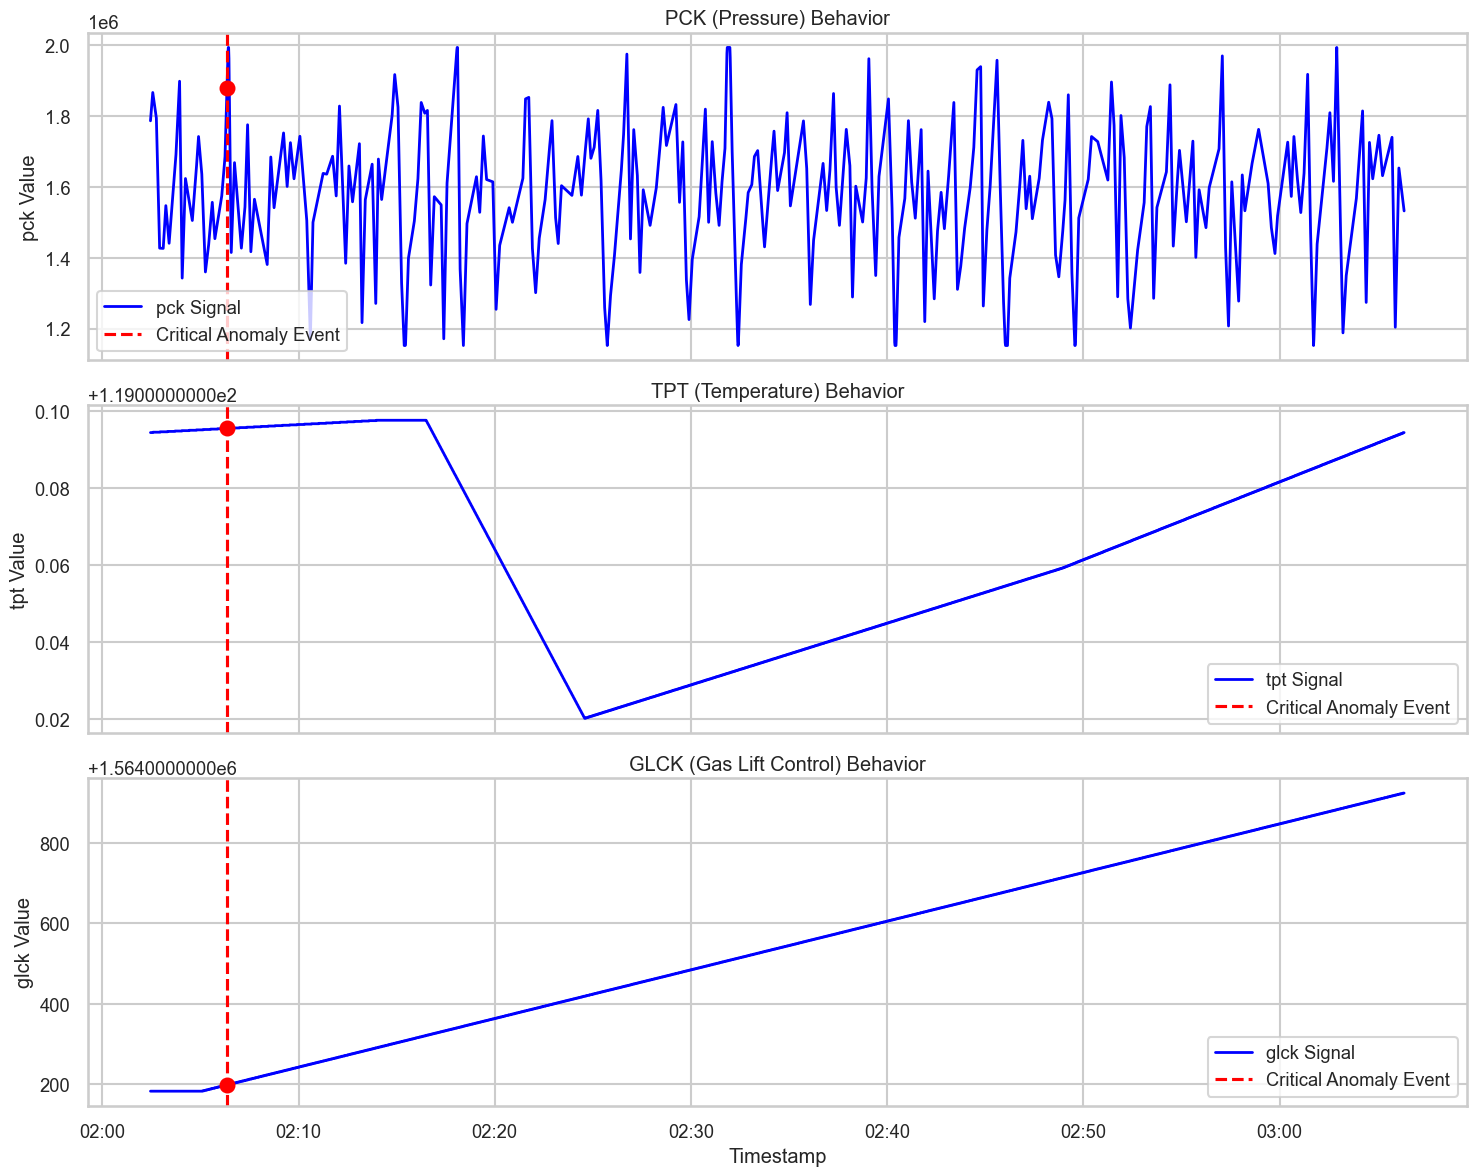

Detailed Analysis of Anomaly at 2017-02-01 02:06
This visualization shows the sensor behavior ± 1 hour around the critical anomaly point captured by the model.


In [37]:
if df['is_anomaly_iforest'].sum() > 0:
    critical_time = df[df['is_anomaly_iforest'] == 1].index[0] 
    start_time = critical_time - pd.Timedelta(hours=1)
    end_time = critical_time + pd.Timedelta(hours=1)
    zoom_df = df.loc[start_time:end_time]

    fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
    target_cols = ['pck', 'tpt', 'glck']
    titles = ['PCK (Pressure) Behavior', 'TPT (Temperature) Behavior', 'GLCK (Gas Lift Control) Behavior']

    for i, col in enumerate(target_cols):
        axes[i].plot(zoom_df.index, zoom_df[col], label=f'{col} Signal', color='blue', linewidth=2)
        axes[i].axvline(critical_time, color='red', linestyle='--', label='Critical Anomaly Event')
        axes[i].scatter(critical_time, zoom_df.loc[critical_time, col], color='red', s=100, zorder=5)
        axes[i].set_title(titles[i])
        axes[i].set_ylabel(f'{col} Value')
        axes[i].legend()

    axes[-1].set_xlabel('Timestamp')
    plt.gca().xaxis.set_major_formatter(DateFormatter("%H:%M"))
    plt.tight_layout()
    plt.show()

    print(f"Detailed Analysis of Anomaly at {critical_time.strftime('%Y-%m-%d %H:%M')}")
    print("This visualization shows the sensor behavior ± 1 hour around the critical anomaly point captured by the model.")
else:
    print("\nWARNING: No anomaly was detected by the models, so the Event Investigation graph could not be generated.")

**************
**PCK (Pressure):** A rapid **drop or increase trend** is observed at the time of the anomaly. This indicates a sudden energy change in the system. 
**TPT (Temperature):** Simultaneously, the temperature signal has either **become unstable or broken its normal trend**.